# AutoML and Timeseries Meetup - Hands On

https://github.com/NeuralAlgorithms/firefly-tutorials/tree/master/meetup_automl_timeseries


## Setup

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import RidgeCV, ARDRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from tsfresh.feature_extraction.feature_calculators import mean, variance, number_peaks, approximate_entropy, median, \
    fft_coefficient, cwt_coefficients,  autocorrelation

## Example Time Series Data Set

Average time step: 0 days 01:00:00


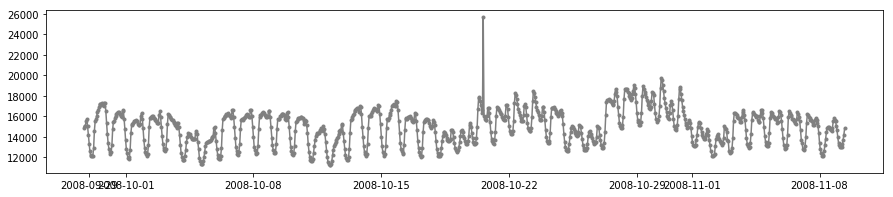

In [2]:
start_sample = 35000
end_sample = 36000

df = pd.read_csv('data/AEP_hourly.csv', parse_dates=['Datetime'])

# sort dates ascending
df = df.set_index(['Datetime'])
df = df.sort_index()
df = df.reset_index()

t = df.Datetime[start_sample:end_sample]
y = df.AEP_MW[start_sample:end_sample]

plt.figure(figsize=(15,3))
plt.plot(t, y, '.-', c='gray')

t_diff_median = t.diff().median()
print('Average time step: {!s}'.format(t_diff_median))

## Fitting a Model

In [3]:
def fit_model(t, X, y, test_size=0.2, estimator=None, plot=False):
    
    # create holdout set
    if isinstance(test_size, float):
        test_size = int(test_size * len(t))
    t_train = t[:-test_size]
    t_test = t[-test_size:]
    x_train = X[:-test_size]
    x_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]

    #     # standardize
    #     numeric_cols = X.select_dtypes(include=[np.number]).columns
    #     centers = X.loc[train, numeric_cols].mean(axis=0)
    #     scales = np.maximum(1e-15, X.loc[train, numeric_cols].std(axis=0))
    #     X[numeric_cols] = (X[numeric_cols] - centers)/scales

    # fit model
    if estimator is None:
#         estimator = ElasticNetCV(n_alphas=100, l1_ratio=0.9, cv=5, random_state=123)
        estimator = RidgeCV(cv=5)

    #     estimator.fit(X.loc[train, :], y[train])
    estimator.fit(x_train, y_train)

    test_score = estimator.score(x_test, y_test)

    # plot the fit
    if plot:
        plt.figure(figsize=(9, 3))
        plt.plot(t, y, '.', c='gray', alpha=0.7)
        plt.plot(t_train, estimator.predict(x_train), 'b-', lw=2, alpha=0.7)
        plt.plot(t_test, estimator.predict(x_test), 'r-', lw=2, alpha=0.7)
        plt.annotate('Test Score: {}'.format(test_score),
                     xy=(0, 1), xytext=(12, -12), va='top',
                     xycoords='axes fraction', textcoords='offset points')
        plt.show()
    return estimator, test_score


def feature_importance_summary(model, columns):
    if hasattr(model, 'coef_'):
        coef = pd.Series(model.coef_, index=columns, name='Importance')
        importances = coef.abs()
        importances.sort_values(ascending=False, inplace=True)
        importances = importances[importances > 1e-15]
        display(importances.to_frame().style.bar())
    else:
        raise NotImplemented('Only linear models supported at the momemnt.')



In [26]:
print("Calculating features. Please wait...")
window = 48
_mean = []
_median = []
_variance = []
_entropy = []
_peaks = []
_autocorrelation = []
dates = []
values = []
df_sub = df[start_sample:end_sample].copy()
df_sub.index -= start_sample
series_size = end_sample - start_sample
for i in range(window+1, series_size):
    dates.append(df_sub.Datetime[i])
    values.append(df_sub.AEP_MW[i])
    _mean.append(mean(df_sub.AEP_MW[i-window:i]))
#     _median.append(median(df_sub.AEP_MW[i-window:i]))
#     _variance.append(variance(df_sub.AEP_MW[i-window:i]))
#     _peaks.append(number_peaks(df_sub.AEP_MW[i-window:i], 3))
#     _entropy.append(approximate_entropy(df_sub.AEP_MW[i-window:i], 10, 0.7))
#     _autocorrelation.append(autocorrelation(df_sub.AEP_MW[i-window:i], 1))


# lags
lags = {}
n_lags = 40
for i in range(1,n_lags):
    lags[i] = df_sub.AEP_MW.shift(i)
    

df_lags = df_sub.copy()

for i in range(1,n_lags):
    df_lags['lag' + str(i)] = 0

for i in range(1,n_lags):
    df_lags['lag' + str(i)] = lags[i]

# df_lags = df_lags.dropna()


df_features = df_lags.copy()

# additional statistical features
df_features['mean'] = 0
# df_features['median'] = 0
# df_features['variance'] = 0
# df_features['entropy'] = 0

df_features.AEP_MW = df_features.AEP_MW.astype(int)
df_features['mean'][window+1:series_size] = np.asarray(_mean)
# df_features['median'][window+1:series_size] = np.asarray(_median)
# df_features['variance'][window+1:series_size] = np.asarray(_variance)
# df_features['entropy'][window+1:series_size] = np.asarray(_entropy)

df_features = df_features.dropna()


df_train = df_features[window + 1:series_size]
df_train.describe()


Calculating features. Please wait...


,AEP_MW,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,mean
count,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,...,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000
mean,14957.635965,14958.769737,14959.574561,14958.990132,14957.994518,14957.049342,14956.302632,14955.805921,14955.569079,14955.889254,...,14964.250000,14964.652412,14965.651316,14967.220395,14968.770833,14970.481360,14971.751096,14972.099781,14972.336623,14965.025562
std,1712.486145,1712.739840,1712.555344,1713.071064,1714.325886,1715.642608,1716.659777,1717.291580,1717.555915,1717.288895,...,1720.030425,1719.476199,1718.451365,1717.645016,1717.732672,1718.553295,1719.262389,1719.432943,1719.569700,949.663009
min,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,...,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,13227.666667
25%,13580.750000,13580.750000,13580.750000,13572.250000,13572.250000,13572.250000,13572.250000,13572.250000,13572.250000,13580.750000,...,13580.750000,13580.750000,13591.250000,13597.000000,13597.000000,13597.000000,13597.000000,13597.000000,13597.000000,14284.984375
50%,15107.000000,15117.000000,15117.000000,15117.000000,15117.000000,15117.000000,15117.000000,15117.000000,15117.000000,15117.000000,...,15174.000000,15174.000000,15174.000000,15174.000000,15178.000000,15183.000000,15183.000000,15183.000000,15183.000000,14946.135417
75%,16082.250000,16082.250000,16082.250000,16082.250000,16082.250000,16082.250000,16082.250000,16082.250000,16082.250000,16082.250000,...,16085.000000,16085.000000,16085.000000,16085.000000,16085.000000,16093.250000,16101.250000,16101.250000,16101.250000,15298.572917
max,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,...,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,25695.000000,17436.208333


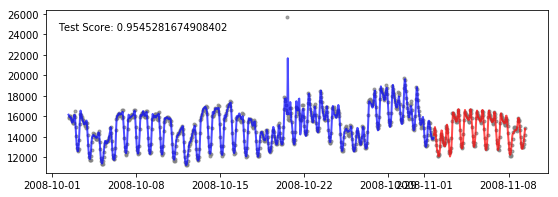

Test score: 0.9545


,Importance
lag1,0.621539
mean,0.242571
lag24,0.198564
lag2,0.19341
lag23,0.18633
lag26,0.154366
lag27,0.114737
lag6,0.0925356
lag22,0.0800871
lag3,0.074081


In [27]:
t = df_train.Datetime
X = df_train.drop(['Datetime', 'AEP_MW'], axis=1)
y = df_train.AEP_MW

# fit
model, score = fit_model(t.values, X.values, y.values, plot=True)
print("Test score: {:.4g}".format(score))
# display importances
feature_importance_summary(model, X.columns)


## Number of Lags

Text(0, 0.5, 'Test Score')

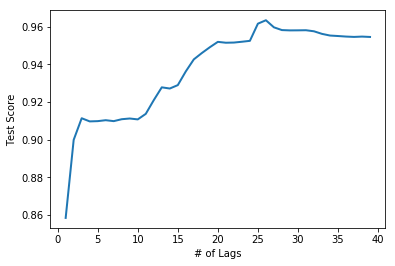

In [30]:
t = df_train.Datetime
y = df_train.AEP_MW

scores = []
lag_count = []
for i in range(1,n_lags):
    drop_columns = ['Datetime', 'AEP_MW']
    for l in range(1,i):
        drop_columns.append('lag' + str(n_lags-l))
        
    X = df_train.drop(drop_columns, axis=1)
    
    # fit
    model, score = fit_model(t.values, X.values, y.values, plot=False)
    scores.append(score)
    lag_count.append(n_lags-i)
    
plt.figure()
plt.plot(lag_count, scores, lw=2)
plt.xlabel('# of Lags')
plt.ylabel('Test Score')
